In [ ]:
# from Hopf_ESDC1A import *
from rushisland_Hopf_subcritical import *

In [1]:
import numpy as np
import numdifftools as nd
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline 
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy import optimize
np.set_printoptions(precision=25)
%load_ext autoreload
%autoreload 2

In [ ]:
print(sys_fun(x))
sol = optimize.root(sys_fun, x, method='hybr')
print(sol.message)
J = np.array([nd.Jacobian(f)(sol.x).ravel() for f in all_fun])
lam, v = np.linalg.eig(J)
print(lam)

In [ ]:
from scipy.integrate import solve_ivp
def func_ty(t, x): 
    return sys_fun(x)

atol = 1e-8
rtol = 1e-8

fs = 120
tend = 100
x0 = sol.x
x0[3] +=  0.0001
x0[10] -= 0.0001

sol = solve_ivp(func_ty, [0,tend], x0, method='RK45', t_eval=np.arange(0,tend,1/fs), atol=atol, rtol=rtol)
result = np.column_stack( (sol.t, sol.y.T) )

In [ ]:
tspan = 300
x0 = sol.y[:,-1]
sol = solve_ivp(func_ty, [tend+1/fs,tend+tspan], x0, method='RK45', t_eval=np.arange(tend+1/fs,tend+tspan,1/fs), atol=atol, rtol=rtol)
# sol = solve_ivp(func_ty, [tend+1/fs,tend+tspan], x0, method='BDF', t_eval=np.arange(tend+1/fs,tend+tspan,1/fs), jac=Jac, atol=atol, rtol=rtol)
tend = tend+tspan
result = np.row_stack( (result, np.column_stack( (sol.t, sol.y.T) )) )

In [ ]:
fig, ax = plt.subplots(nrows=7,ncols=1,figsize=(14,18))
start, end = 0*fs, 1000*fs

time = result[start:end,0]
data = result[start:end,1:]
for i in range(7):
    ax[i].plot(time, data[:,i],   label = 'Gen1')
    ax[i].plot(time, data[:,i+7], label = 'Gen2')

#[ax[i].legend() for i in range(7)]

ax[0].set_ylabel('Eqp')
ax[1].set_ylabel('Edp')
ax[2].set_ylabel('delta')
ax[3].set_ylabel('w')
ax[4].set_ylabel('VF')
ax[5].set_ylabel('VA')
ax[6].set_ylabel('VE')
ax[6].set_xlabel('time(sec)')

In [ ]:
import scipy.io as io
io.savemat('Hopf_Sup_Pm1=5p2_100sec_stableEq.mat',{'data':result})

In [7]:
import scipy.io as io
result = io.loadmat('Hopf_Sub_Pm1=7p4_x+0p00681_95sec_unstable.mat')
result = result['data']
fs = 120

Text(0.5, 0, 'time(sec)')

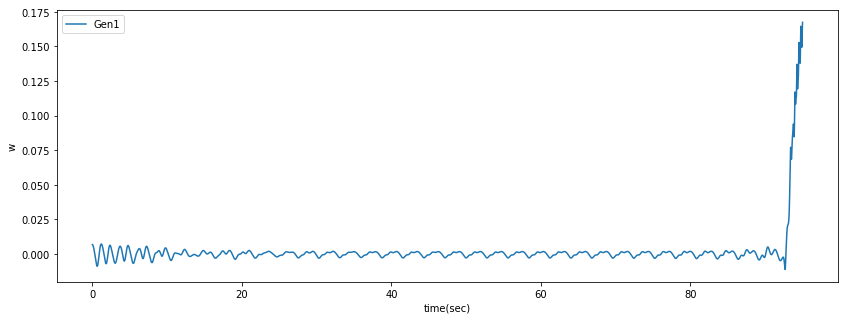

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,5))
start, end = 0*fs, 100*fs

time = result[start:end,0]
data = result[start:end,1:]
i=3
ax.plot(time, data[:,i],   label = 'Gen1')
# ax.plot(time, data[:,i+7], label = 'Gen2')

#[ax[i].legend() for i in range(7)]

ax.set_ylabel('w')
ax.legend()
ax.set_xlabel('time(sec)')

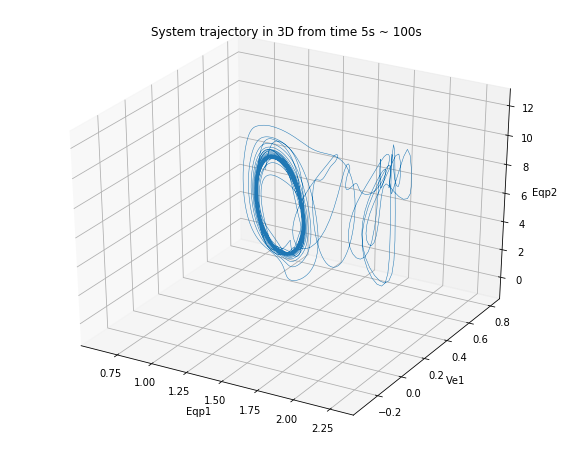

In [9]:
from mpl_toolkits.mplot3d import Axes3D
# fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
# ax[0][0].plot(data[:,0],data[:,7]);  ax[0][0].set_xlabel('Eqp1');   ax[0][0].set_ylabel('Eqp2')
# ax[0][1].plot(data[:,1],data[:,8]);  ax[0][1].set_xlabel('Edp1');   ax[0][1].set_ylabel('Edp2')
# ax[1][0].plot(data[:,2],data[:,9]);  ax[1][0].set_xlabel('delta1'); ax[1][0].set_ylabel('delta2')
# ax[1][1].plot(data[:,3],data[:,10]); ax[1][1].set_xlabel('w1');     ax[1][1].set_ylabel('w2')

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

start = 5*fs
end = 100*fs
data = result[start:end,1:]
xs = data[:,0]
ys = data[:,1]
zs = data[:,6]

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("Eqp1")
ax.set_ylabel("Ve1")
ax.set_zlabel("Eqp2")
ax.set_title("System trajectory in 3D from time {}s ~ {}s".format(int(start/120),int(end/120)))
plt.show()